<a href="https://colab.research.google.com/github/bochendong/diffusion-model/blob/main/DDPM/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math
import os
import glob
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange
from torchvision.utils import save_image

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The noise schedule:


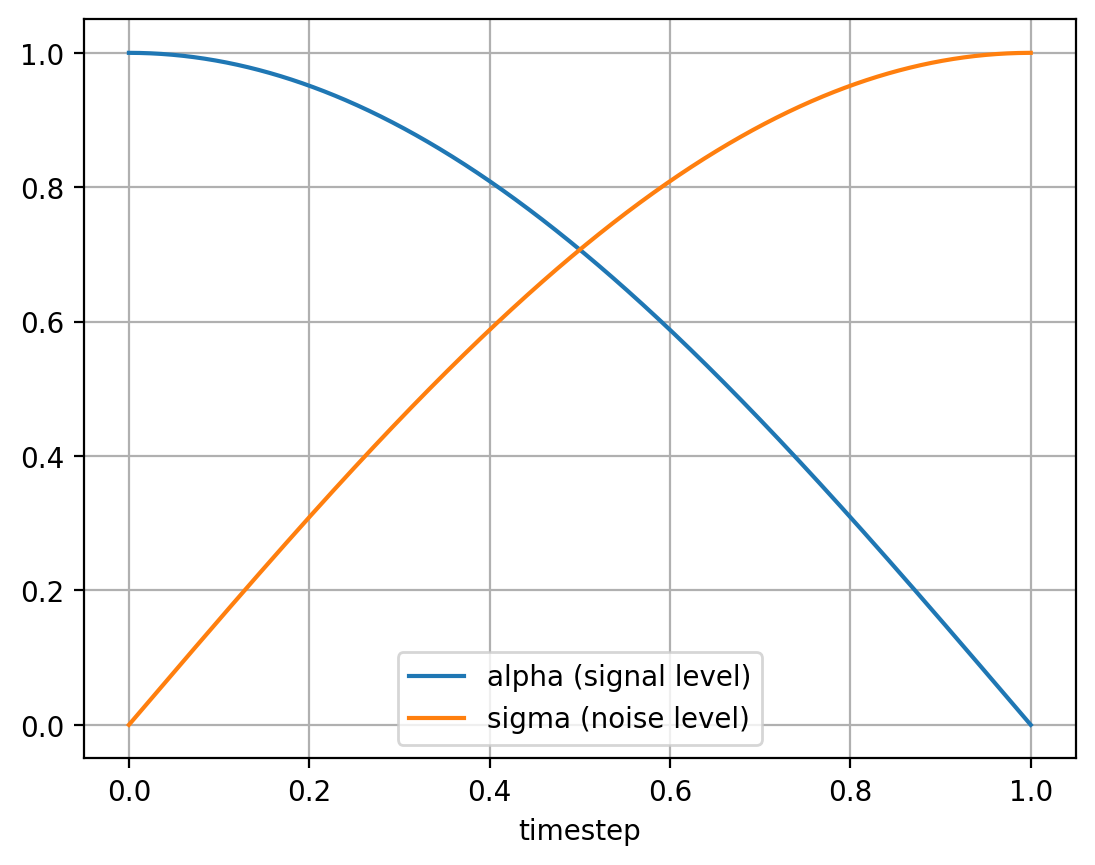

In [43]:
def get_alphas_sigmas(t):
    """
    Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep.
    """
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
alphas_vis, sigmas_vis = get_alphas_sigmas(t_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()

In [44]:
batch_size = 100
epoches = 30

# Actually train the model
ema_decay = 0.999

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
eta = 1.

# Classifier-free guidance scale (0 is unconditional, 1 is conditional)
guidance_scale = 2.


tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_set = datasets.CIFAR10('data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
if (os.path.exists("./output")) == False:
    os.mkdir("output")

files = glob.glob("./output/*.png")

for f in files:
    os.remove(f)

In [46]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, is_last=False):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if not is_last else nn.Identity(),
            nn.ReLU(inplace=True) if not is_last else nn.Identity(),
        ], skip)


class SelfAttention2d(nn.Module):
    def __init__(self, c_in, n_head=1, dropout_rate=0.1):
        super().__init__()
        assert c_in % n_head == 0
        self.norm = nn.GroupNorm(1, c_in)
        self.n_head = n_head
        self.qkv_proj = nn.Conv2d(c_in, c_in * 3, 1)
        self.out_proj = nn.Conv2d(c_in, c_in, 1)
        self.dropout = nn.Dropout2d(dropout_rate, inplace=True)

    def forward(self, input):
        n, c, h, w = input.shape
        qkv = self.qkv_proj(self.norm(input))
        qkv = qkv.view([n, self.n_head * 3, c // self.n_head, h * w]).transpose(2, 3)
        q, k, v = qkv.chunk(3, dim=1)
        scale = k.shape[3]**-0.25
        att = ((q * scale) @ (k.transpose(2, 3) * scale)).softmax(3)
        y = (att @ v).transpose(2, 3).contiguous().view([n, c, h, w])
        return input + self.dropout(self.out_proj(y))


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)
        self.class_embed = nn.Embedding(11, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        SelfAttention2d(c * 4, c * 4 // 64),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    SelfAttention2d(c * 2, c * 2 // 64),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, is_last=True),
        )

    def forward(self, input, t, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))

In [47]:
@torch.no_grad()
def sample(model, x, steps, eta, classes, guidance_scale=1.):
    """
    Draws samples from a model given starting noise.
    """
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            x_in = torch.cat([x, x])
            ts_in = torch.cat([ts, ts])
            classes_in = torch.cat([-torch.ones_like(classes), classes])
            v_uncond, v_cond = model(x_in, ts_in * t[i], classes_in).float().chunk(2)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred

In [55]:
class FeatureIntegration(nn.Module):
    def __init__(self, feature_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, features):
        return self.activation(self.fc1(features))

# Assuming the pre-trained feature dimension is 2048, and we want to integrate these into a 64x8x8 feature map
feature_integration_output_dim = 64 * 8 * 8  # Adjust as needed to fit your model's architecture

class DiffusionWithFeatures(Diffusion):
    def __init__(self):
        super().__init__()
        feature_integration_output_dim = 64 * 32 * 32  # Assuming we need to reshape to 32 x 32
        self.feature_integration = FeatureIntegration(2048, feature_integration_output_dim)
        # Adding a layer to adjust channels after concatenation
        self.adjust_channels = nn.Conv2d(87, 23, kernel_size=1)  # Adjusting to the expected channels

    def forward(self, input, t, cond, external_features=None):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        combined_input = torch.cat([input, class_embed, timestep_embed], dim=1)

        if external_features is not None:
            external_features = self.feature_integration(external_features)
            external_features = external_features.view(-1, 64, 32, 32)  # Reshape to match combined_input
            combined_input = torch.cat([combined_input, external_features], dim=1)
            combined_input = self.adjust_channels(combined_input)  # Adjust channels

        return self.net(combined_input)




In [49]:
rng = torch.quasirandom.SobolEngine(1, scramble=True)

In [50]:
def train_model(model, optimizer, train_dl, epochs, device):
    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_dl):
            images, labels = images.to(device), labels.to(device)

            # Generate random timesteps
            t = rng.draw(labels.shape[0])[:, 0].to(device)

            # Get alphas and sigmas
            alphas, sigmas = get_alphas_sigmas(t)

            # Apply noise model
            noise = torch.randn_like(images)
            noised_images = images * alphas[:, None, None, None] + noise * sigmas[:, None, None, None]

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                output = model(noised_images, t, labels)
                loss = F.mse_loss(output, noise)  # Example loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        print(f"Epoch {epoch+1}: Loss = {loss.item()}")
        noise = torch.randn([10, 3, 32, 32], device=device)
        fakes_classes = torch.arange(10, device=device)

        fakes = sample(model, noise, steps, eta, fakes_classes, guidance_scale)
        fakes = (fakes + 1) / 2
        fakes = torch.clamp(fakes, min=0, max = 1)
        save_image(fakes.data, './output/%03d_train.png' % epoch)

In [51]:
def train_with_features(model, optimizer, train_dl, feature_dl, epochs, device):
    for epoch in range(epochs):
        model.train()
        for i, ((reals, classes), (features, feature_labels)) in enumerate(zip(train_dl, feature_dl)):
            optimizer.zero_grad()
            reals, classes = reals.to(device), classes.to(device)
            features = features.to(device)

            t = rng.draw(reals.shape[0])[:, 0].to(device)
            alphas, sigmas = get_alphas_sigmas(t)
            alphas = alphas[:, None, None, None]
            sigmas = sigmas[:, None, None, None]
            noise = torch.randn_like(reals)
            noised_reals = reals * alphas + noise * sigmas
            targets = noise * alphas - reals * sigmas

            with torch.cuda.amp.autocast():
                v = model(noised_reals, t, classes, external_features=features)
                loss = F.mse_loss(v, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        noise = torch.randn([10, 3, 32, 32], device=device)
        fakes_classes = torch.arange(10, device=device)

        fakes = sample(model, noise, steps, eta, fakes_classes, guidance_scale)
        fakes = (fakes + 1) / 2
        fakes = torch.clamp(fakes, min=0, max = 1)
        save_image(fakes.data, './output/%03d_imagine.png' % epoch)

In [56]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = datasets.CIFAR10(root='data', train=True, download=True, transform=tf, target_transform=lambda x: x if x < 5 else -1)
train_dl = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

model = DiffusionWithFeatures().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()


Files already downloaded and verified


In [53]:
train_model(model, optimizer, train_dl, epochs=30, device=device)

In [13]:
from torchvision.models import resnet50

In [14]:
# Load a pre-trained ResNet50 model
pretrained_model = resnet50(pretrained=True)
pretrained_model.fc = nn.Identity()  # Modify to return features instead of classification
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

def extract_and_load_features(dataset, feature_extractor, device):
    feature_extractor.eval()
    features = []
    labels = []
    for image, label in tqdm(dataset):
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            extracted_feature = feature_extractor(image).squeeze(0)  # Remove batch dimension
        features.append(extracted_feature.cpu())
        labels.append(label)
    features_tensor = torch.stack(features)
    labels_tensor = torch.tensor(labels)
    return DataLoader(TensorDataset(features_tensor, labels_tensor), batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

# Assuming you have a dataset with images for classes 5-7
stage2_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=tf, target_transform=lambda x: x if 5 <= x <= 7 else -1)
feature_dl = extract_and_load_features(stage2_dataset, pretrained_model, device)

Files already downloaded and verified


  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# Train the model with features
train_with_features(model, optimizer, train_dl, feature_dl, epochs=30, device=device)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
'''def train(epoch):
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Draw uniformly distributed continuous timesteps
        t = rng.draw(reals.shape[0])[:, 0].to(device)

        # Calculate the noise schedule parameters for those timesteps
        alphas, sigmas = get_alphas_sigmas(t)

        # Combine the ground truth images and the noise
        alphas = alphas[:, None, None, None]
        sigmas = sigmas[:, None, None, None]
        noise = torch.randn_like(reals)

        # with t increase, alpha goes down and sigmas goes up
        # which means with t increase, noised_reals will have more noise and less image
        noised_reals = reals * alphas + noise * sigmas

        # with t increase, alpha goes down and sigmas goes up
        # which means with t increase, targets will closer to - img
        targets = noise * alphas - reals * sigmas

        # Drop out the class on 20% of the examples
        to_drop = torch.rand(classes.shape, device=classes.device).le(0.2)
        classes_drop = torch.where(to_drop, -torch.ones_like(classes), classes)

        # Compute the model output and the loss.
        with torch.cuda.amp.autocast():
            v = model(noised_reals, t, classes_drop)
            loss = F.mse_loss(v, targets)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)


        # ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')

    noise = torch.randn([10, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device)

    fakes = sample(model, noise, steps, eta, fakes_classes, guidance_scale)
    fakes = (fakes + 1) / 2
    fakes = torch.clamp(fakes, min=0, max = 1)
    save_image(fakes.data, './output/%03d.png' % epoch)
'''

In [ ]:
'''try:
    i = 0
    while True:
        i += 1
        train(i)
except KeyboardInterrupt:
    pass'''